In [1]:
from __future__ import absolute_import, division, print_function
import re
import json
import pandas as pd  
import numpy as np
import string, os 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import unicodedata
import time
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_datasets as tfds
import pickle


print('Tensorflow version', tf.__version__)

%env CUDA_VISIBLE_DEVICES=0,1
%env CUDA_VISIBLE_DEVICES

W0809 09:40:21.753526 139734579894080 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Tensorflow version 1.14.0
env: CUDA_VISIBLE_DEVICES=0,1


'0,1'

In [2]:
tf.test.is_gpu_available()

True

In [3]:
#load the saved df with gold training data having concatenated reviews
with open('../data/dataframe_nearest_1day.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
data.axes

[RangeIndex(start=0, stop=54676, step=1),
 Index(['index', 'business_id', 'user_id', 'compliment_count', 'date', 'text_x',
        'cool', 'funny', 'review_id', 'stars', 'text_y', 'useful'],
       dtype='object')]

In [5]:
#Prep data according to the input format
#Replace new line (\n) with the user-defined token
path_to_data = '../data/reviews_and_tips_nearest_1day.txt'
data = data.drop(['index', 'cool', 'date', 'cool', 'funny', 'review_id', 'stars', 'useful', 'compliment_count', 'business_id', 'user_id'], axis = 1)
data.text_x = data.text_x.apply(lambda x: x.replace('\n', '<newline>'))
data.text_y = data.text_y.apply(lambda x: x.replace('\n', '<newline>'))

In [6]:
train_review, test_review, train_tip, test_tip = train_test_split(data.text_y, data.text_x, test_size=0.1, random_state=9)

In [7]:
train = tf.data.Dataset.from_tensor_slices((train_review.values, train_tip.values))

In [8]:
test = tf.data.Dataset.from_tensor_slices((test_review.values, test_tip.values))

In [9]:
tokenizer_tip = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (tip.numpy() for review, tip in train), target_vocab_size=2**13)

tokenizer_review = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (review.numpy() for review, tip in train), target_vocab_size=2**13)

tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (tip.numpy() for review, tip in train), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (review.numpy() for review, tip in train), target_vocab_size=2**13)

In [10]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

In [11]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

In [12]:
MAX_LENGTH_1 = 1050
MAX_LENGTH_2 = 250
def filter_max_length(x, y, max_length_1=MAX_LENGTH_1, max_length_2=MAX_LENGTH_2):
  return tf.logical_and(tf.size(x) <= max_length_1,
                        tf.size(y) <= max_length_2)

In [13]:
def tf_encode(pt, en):
  return tf.py_function(encode, [pt, en], [tf.int64, tf.int64])

In [14]:
train_dataset = train.map(tf_encode)

In [15]:
train

<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>

In [16]:
train_dataset = train.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = test.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))

In [17]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

W0809 09:42:47.682407 139726921115392 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0809 09:42:47.683914 139726921115392 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0809 09:42:47.687148 139726921115392 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0809 09:42:47.688206 139726921115392 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0809 09:42:47.702458 139726921115392 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string


(<tf.Tensor: id=590815, shape=(32, 240), dtype=int64, numpy=
 array([[8187,   59,   10, ...,    0,    0,    0],
        [8187,   78, 2610, ...,    0,    0,    0],
        [8187, 1887,  646, ...,    0,    0,    0],
        ...,
        [8187, 6564, 7973, ...,    0,    0,    0],
        [8187, 1833, 8047, ...,    0,    0,    0],
        [8187,   53,   22, ...,    0,    0,    0]])>,
 <tf.Tensor: id=590816, shape=(32, 33), dtype=int64, numpy=
 array([[8125,   51,   12, ...,    0,    0,    0],
        [8125,  140, 2053, ...,    0,    0,    0],
        [8125, 7922, 1451, ...,    0,    0,    0],
        ...,
        [8125,  231,  125, ...,    0,    0,    0],
        [8125, 5463, 3171, ...,    0,    0,    0],
        [8125,   11,   10, ...,    0,    0,    0]])>)

In [18]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [19]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [20]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [21]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [60]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [23]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [25]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [26]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [27]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [28]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [29]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [30]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [31]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [33]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [35]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [36]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [37]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

In [38]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [39]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [40]:
EPOCHS = 20

In [41]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [42]:
%%time
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Tensor("transformer/encoder/encoder_layer/multi_head_attention/Cast:0", shape=(), dtype=float32)
Tensor("transformer/encoder/encoder_layer_1/multi_head_attention_1/Cast:0", shape=(), dtype=float32)
Tensor("transformer/encoder/encoder_layer_2/multi_head_attention_2/Cast:0", shape=(), dtype=float32)
Tensor("transformer/encoder/encoder_layer_3/multi_head_attention_3/Cast:0", shape=(), dtype=float32)
Tensor("transformer/decoder/decoder_layer/multi_head_attention_4/Cast:0", shape=(), dtype=float32)
Tensor("transformer/decoder/decoder_layer/multi_head_attention_5/Cast:0", shape=(), dtype=float32)
Tensor("transformer/decoder/decoder_layer_1/multi_head_attention_6/Cast:0", shape=(), dtype=float32)
Tensor("transformer/decoder/decoder_layer_1/multi_head_attention_7/Cast:0", shape=(), dtype=float32)
Tensor("transformer/decoder/decoder_layer_2/multi_head_attention_8/Cast:0", shape=(), dtype=float32)
Tensor("transformer/decoder/decoder_layer_2/multi_head_attention_9/Cast:0", shape=(), dtype=float32

Epoch 4 Batch 1350 Loss 1.6638 Accuracy 0.1044
Epoch 4 Batch 1400 Loss 1.6609 Accuracy 0.1046
Epoch 4 Batch 1450 Loss 1.6597 Accuracy 0.1046
Epoch 4 Batch 1500 Loss 1.6608 Accuracy 0.1051
Epoch 4 Loss 1.6601 Accuracy 0.1052
Time taken for 1 epoch: 138.78315901756287 secs

Epoch 5 Batch 0 Loss 1.8315 Accuracy 0.1140
Epoch 5 Batch 50 Loss 1.6814 Accuracy 0.1199
Epoch 5 Batch 100 Loss 1.6605 Accuracy 0.1177
Epoch 5 Batch 150 Loss 1.6578 Accuracy 0.1149
Epoch 5 Batch 200 Loss 1.6345 Accuracy 0.1128
Epoch 5 Batch 250 Loss 1.6359 Accuracy 0.1136
Epoch 5 Batch 300 Loss 1.6187 Accuracy 0.1130
Epoch 5 Batch 350 Loss 1.6060 Accuracy 0.1115
Epoch 5 Batch 400 Loss 1.5975 Accuracy 0.1099
Epoch 5 Batch 450 Loss 1.6008 Accuracy 0.1111
Epoch 5 Batch 500 Loss 1.5989 Accuracy 0.1114
Epoch 5 Batch 550 Loss 1.5988 Accuracy 0.1116
Epoch 5 Batch 600 Loss 1.5925 Accuracy 0.1118
Epoch 5 Batch 650 Loss 1.5880 Accuracy 0.1111
Epoch 5 Batch 700 Loss 1.5862 Accuracy 0.1117
Epoch 5 Batch 750 Loss 1.5837 Accuracy 0

Epoch 10 Batch 300 Loss 1.3544 Accuracy 0.1362
Epoch 10 Batch 350 Loss 1.3439 Accuracy 0.1344
Epoch 10 Batch 400 Loss 1.3373 Accuracy 0.1323
Epoch 10 Batch 450 Loss 1.3405 Accuracy 0.1336
Epoch 10 Batch 500 Loss 1.3398 Accuracy 0.1340
Epoch 10 Batch 550 Loss 1.3404 Accuracy 0.1342
Epoch 10 Batch 600 Loss 1.3356 Accuracy 0.1343
Epoch 10 Batch 650 Loss 1.3325 Accuracy 0.1335
Epoch 10 Batch 700 Loss 1.3318 Accuracy 0.1342
Epoch 10 Batch 750 Loss 1.3305 Accuracy 0.1346
Epoch 10 Batch 800 Loss 1.3296 Accuracy 0.1344
Epoch 10 Batch 850 Loss 1.3295 Accuracy 0.1340
Epoch 10 Batch 900 Loss 1.3298 Accuracy 0.1342
Epoch 10 Batch 950 Loss 1.3297 Accuracy 0.1339
Epoch 10 Batch 1000 Loss 1.3309 Accuracy 0.1343
Epoch 10 Batch 1050 Loss 1.3275 Accuracy 0.1335
Epoch 10 Batch 1100 Loss 1.3248 Accuracy 0.1329
Epoch 10 Batch 1150 Loss 1.3256 Accuracy 0.1330
Epoch 10 Batch 1200 Loss 1.3260 Accuracy 0.1334
Epoch 10 Batch 1250 Loss 1.3258 Accuracy 0.1336
Epoch 10 Batch 1300 Loss 1.3251 Accuracy 0.1337
Epoch 

Epoch 16 Batch 150 Loss 1.2597 Accuracy 0.1521
Epoch 16 Batch 200 Loss 1.2437 Accuracy 0.1491
Epoch 16 Batch 250 Loss 1.2443 Accuracy 0.1505
Epoch 16 Batch 300 Loss 1.2321 Accuracy 0.1496
Epoch 16 Batch 350 Loss 1.2231 Accuracy 0.1475
Epoch 16 Batch 400 Loss 1.2172 Accuracy 0.1453
Epoch 16 Batch 450 Loss 1.2200 Accuracy 0.1467
Epoch 16 Batch 500 Loss 1.2197 Accuracy 0.1470
Epoch 16 Batch 550 Loss 1.2209 Accuracy 0.1471
Epoch 16 Batch 600 Loss 1.2171 Accuracy 0.1472
Epoch 16 Batch 650 Loss 1.2140 Accuracy 0.1463
Epoch 16 Batch 700 Loss 1.2132 Accuracy 0.1470
Epoch 16 Batch 750 Loss 1.2123 Accuracy 0.1474
Epoch 16 Batch 800 Loss 1.2119 Accuracy 0.1471
Epoch 16 Batch 850 Loss 1.2121 Accuracy 0.1468
Epoch 16 Batch 900 Loss 1.2128 Accuracy 0.1469
Epoch 16 Batch 950 Loss 1.2131 Accuracy 0.1465
Epoch 16 Batch 1000 Loss 1.2143 Accuracy 0.1468
Epoch 16 Batch 1050 Loss 1.2117 Accuracy 0.1459
Epoch 16 Batch 1100 Loss 1.2095 Accuracy 0.1453
Epoch 16 Batch 1150 Loss 1.2104 Accuracy 0.1454
Epoch 16 

In [43]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, tokenizer_en.vocab_size+1):
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [44]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [64]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)
    
  return format(predicted_sentence)

In [50]:
MAX_LENGTH = 200
translate(u'All of my co-workers raved about this place and I finally had the opportunity to try it at lunch.  Wow, this was the most amazing burrito I have ever had.  For me, the flavor was out of this world.  There are other chain restaurants that make burritos that should shudder.  This place rocks.  I have only been two times and am entirely hooked.  the green pork burrito is my favorite so far.  <newline><newline>One piece of advice, if you plan on stopping in for your lunch break (12 p.m.), I would order in advance to save you time in line and waiting for your order.  Seating is all outside, Beach House says it all.')

tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(16.0, 

Input: This was my first time here and I really enjoyed my lunch! I ordered the sesame chicken from the Wok section of the menu and it was delicious.! I look forward to visiting again soon..hopefully it's during the evening so I can experience both atmospheres. <newline><newline>FYI: it's definitely busy during the lunch hour and there are no reservations available. I sat down around 12:30PM and it was a full house.
Predicted translation: Great service, great food. Definitely coming back.


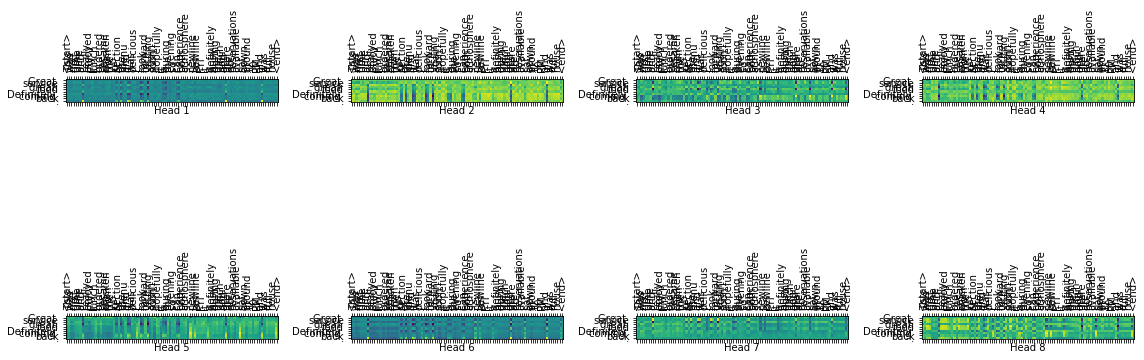

Input: Tomo Japanese Restaurant @ トロント、カナダ<newline><newline>9625 Yonge St, Richmond Hill, ON L4C 5T2, Canada, カナダ<newline><newline>カナダのオンタリオ州トロントの郊外、Richmond Hill にある、韓国人経営の日本食店。<newline><newline>北米の常で外観はパッとしませんが、店内はモノトーンのスタイリッシュなデザイン。ホールスタッフも黒ずくめの韓国人イケメンと美女。<newline><newline>まずは酢の物を頼んだのですが、これが...美味しいんですよ！ 北米の酢の物は一般に酸っぱすぎるのですが、ここのはまるで日本で出される味。期待が高まります。<newline><newline>続いて、チキンの焼きそば、これは野菜たっぷりで、日本のソース焼きそばの味。待てよ、もしかすると、マルちゃんの焼きそばの味かな。何れにしても、馴染みの味が嬉しい。<newline><newline>そして、刺身、寿司盛り合わせのディナープレート、これはお刺身五種、寿司五貫、カリフォルニアロールのセット、しゃりが日本のようにちいさく、ネタが厚いので素晴らしい。単品で頼んだ寿司は、大きなネタでこれもGOOD。シャリは日本の米で、炊き加減バッチリ、酢飯の具合も上品でグッと来ます。<newline><newline>トロントの、日本食はレベルが低いと誰が言ったのでしょうね？<newline><newline><newline>This is really wonderful Sushi as if we are dining in Japan. Quality of rice and Sashimis are excellent. We are visitors from Japan and impressed and enjoyed so much.  I can recommend this restaurant strongly.
Predicted translation: Quick & delicious


/home/nikhil/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/nikhil/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/nikhil/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/nikhil/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/nikhil/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12290 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/nikhil/anaconda3/en

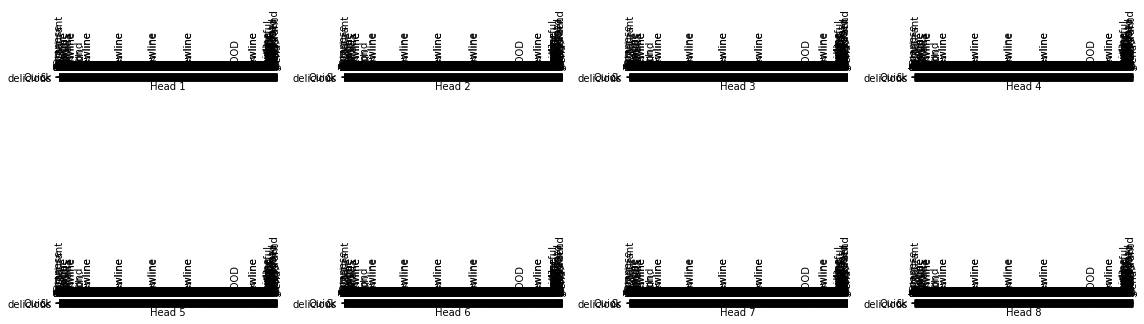

19383    Great service, great food. Definitely coming b...
13174                                    Quick & delicious
Name: text_y, dtype: object

In [66]:
test_review[:2].apply(lambda x: translate(x, plot='decoder_layer4_block2'))